## Loading Dependencies

In [8]:
%pip install pandas
%pip install matplotlib
%pip install plotly
%pip install scikit-learn
%pip install numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Importing Libraries

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import plotly.graph_objects as go

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Stage: Preprocessing
##### Loading in the Badminton Serving Data. 
- Blank rows are used to separarate observations. 
- Non-sparse data are filtered out
- Data is grouped into observations labelled under data column "OBSERVATION GROUP NUMBER"
- Data is also sequenced within each observation group with "OBSERVATION NUMBER"
- There are a total of 365 (index 0 - 364) observation groups here
- Data is indicated as serving data with 1 under data column "SERVING"
#### Code is currently commented out as results has already been extracted

In [10]:
# read csv data from badmintondata.csv
serving_data = pd.read_csv('badmintondata.csv')

# Initialize variables
observation_group_num = 0
observation_num = 0
is_group = False

# Process rows
for index, row in serving_data.iterrows():
    if row['HUMAN PLAYER POSITION (X) metres'] == 0:
        if is_group:
            is_group = False
        serving_data.drop(index, inplace=True)
    elif row['HUMAN PLAYER POSITION (X) metres'] == 4:
        if is_group:
            observation_num+=1
        else:
            is_group = True
            # increase observation group number by 1
            observation_group_num+=1
            # resets observation sequence number to 1
            observation_num = 1
        serving_data.at[index, 'OBSERVATION NUMBER'] = observation_num
        serving_data.at[index, 'OBSERVATION GROUP NUMBER'] = observation_group_num

# Set 'OBSERVATION GROUP NUMBER' and 'SERVING SHOT' columns
serving_data['OBSERVATION NUMBER'] = serving_data['OBSERVATION NUMBER'].astype(int)
serving_data['OBSERVATION GROUP NUMBER'] = serving_data['OBSERVATION GROUP NUMBER'].astype(int)
serving_data['SERVING SHOT'] = 1
serving_data.to_csv('cleaned_served_data_v2.csv')

##### Loading in the Badminton Rallying Data. 
- Blank rows are used to separarate observations. 
- Non-sparse data are filtered out
- Data is grouped into observations labelled under data column "OBSERVATION GROUP NUMBER"
- Data is also sequenced within each observation group with "OBSERVATION NUMBER"
- There are a total of 1212 (index 364 - 1576) observation groups here
- Data is indicated as serving data with 0 under data column "SERVING"
#### Code is currently commented out as results has already been extracted

In [12]:
# read csv data from badmintondata.csv
rally_data = pd.read_csv('badmintondata2.csv')

# Initialize variables
observation_num = 0
is_group = False

# Process rows
for index, row in rally_data.iterrows():
    if row['HUMAN PLAYER POSITION (X) metres'] == 0:
        if is_group:
            is_group = False
        rally_data.drop(index, inplace=True)
    elif row['HUMAN PLAYER POSITION (X) metres'] == 4:
        if is_group:
            observation_num+=1
        else:
            is_group = True
            # increase observation group number by 1
            observation_group_num+=1
            # resets observation sequence number to 1
            observation_num = 1
        rally_data.at[index, 'OBSERVATION NUMBER'] = observation_num
        rally_data.at[index, 'OBSERVATION GROUP NUMBER'] = observation_group_num

# Set 'OBSERVATION GROUP NUMBER' and 'SERVING SHOT' columns
rally_data['OBSERVATION NUMBER'] = rally_data['OBSERVATION NUMBER'].astype(int)
rally_data['OBSERVATION GROUP NUMBER'] = rally_data['OBSERVATION GROUP NUMBER'].astype(int)
rally_data['SERVING SHOT'] = 0
rally_data.to_csv('cleaned_rally_data_v2.csv')

#### Combining preprocessing
- combine cleaned served and rallied dataframes
- label data if they are are out of bounds within the observations using data column "OUT OF BOUNDS". This includes
    - Data that exceeds the X axis (hit too far on both sides) X < 0 OR X > 13.4
    - Data that exceeds the Y axis (hit out of court on left or right side) Y < 0 OR Y > 5.18
    - Data that is out of bounds labelled as 1, no 0
#### Code is currently commented out as results has already been extracted

In [14]:
# combining the serving and rally dataframes
badminton_data = pd.concat([serving_data, rally_data], ignore_index=True)
# labelling data if its out of bounds
unique_observation_number = badminton_data['OBSERVATION GROUP NUMBER'].unique()
for obs_grp_number in unique_observation_number:
    last_row = badminton_data[badminton_data['OBSERVATION GROUP NUMBER'] == obs_grp_number].tail(1)
    # Check the conditions for 'Shuttlecock Position in Air X' and 'Shuttlecock Position in Air Y'
    if (last_row['SHUTTLECOCK POSITIION IN AIR(X ) metres'].values[0] < 0 or
        last_row['SHUTTLECOCK POSITIION IN AIR(X ) metres'].values[0] > 13.4 or
        last_row['SHUTTLECOCK POSITIION IN AIR(Y) metres'].values[0] < 0 or
        last_row['SHUTTLECOCK POSITIION IN AIR(Y) metres'].values[0] > 5.18):
        
        # Set 'OUT OF BOUNDS' column to 1 for the corresponding observation number
        badminton_data.loc[badminton_data['OBSERVATION GROUP NUMBER'] == obs_grp_number, 'OUT OF BOUNDS'] = 1
    else:
        badminton_data.loc[badminton_data['OBSERVATION GROUP NUMBER'] == obs_grp_number, 'OUT OF BOUNDS'] = 0
    
badminton_data.to_csv('cleaned_badminton_v2.csv')

#### Temporary Loading of Data to avoid excessive computation

In [20]:
cleaned_data = pd.read_csv('cleaned_badminton_v2.csv')
# removal indexes
cleaned_data = cleaned_data.drop(columns=['Unnamed: 0'])

### Normalization of Data

In [25]:
# removal of labels and dependent features
X_Features = cleaned_data.drop(columns=['OBSERVATION GROUP NUMBER',
                                            'OUT OF BOUNDS', 
                                            'SHUTTLECOCK POSITIION IN AIR(X ) metres', 
                                            'SHUTTLECOCK POSITIION IN AIR(Y) metres', 
                                            'SHUTTLECOCK POSITIION IN AIR(Z) metres'])
# Standardize the data
scaler = StandardScaler()
X_features_norm = scaler.fit_transform(X_Features)

#### Significance of Independent Features with PCA

Feature INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE): Significance = 0.20089682837636116
Feature OBSERVATION NUMBER: Significance = 0.19379264158479728
Feature HUMAN PLAYER POSITION (Y) metres: Significance = 0.17227876477330392
Feature SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE): Significance = 0.17207745882650718
Feature INITITAL VELOCITY OF SHUTTELCOCK(m/s): Significance = 0.15634985472866794
Feature HUMAN PLAYER POSITION (X) metres: Significance = 0.10460445171036246


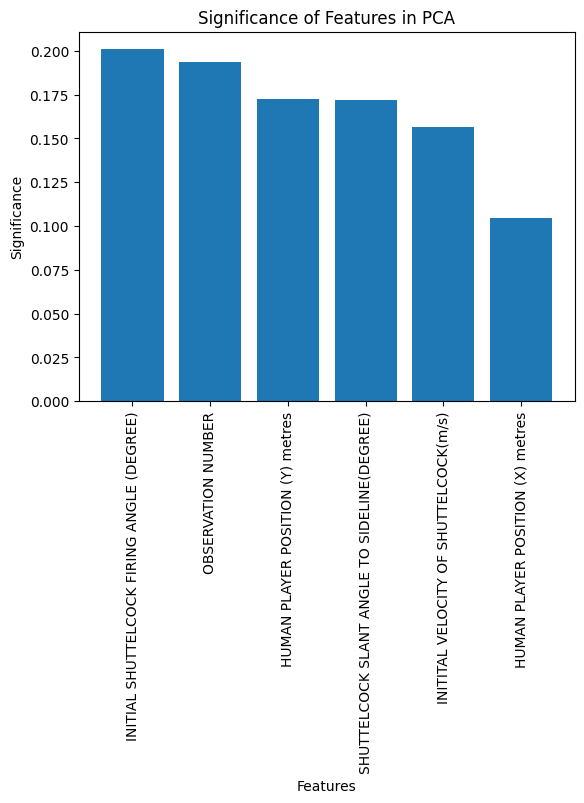

In [29]:
# instantiate PCA object, fit model
pca = PCA()
pca.fit(X_features_norm)

# loadings refer to the coefficients or weights that determine the contribution of each feature to the principal components
# Get the absolute loadings for each feature in each principal component
absolute_loadings = np.abs(pca.components_)
# Calculate the total sum of absolute loadings for each feature across all principal components
total_loadings = np.sum(absolute_loadings, axis=0)

# Calculate the relative contribution of each feature to the total loadings
relative_contribution = total_loadings / np.sum(total_loadings)

# Sort the features based on their relative contribution
sorted_features = np.argsort(relative_contribution)[::-1]
feature_names = X_Features.columns
# Print the significance of each feature
for feature_idx in sorted_features:
    print(f"Feature {feature_names[feature_idx]}: Significance = {relative_contribution[feature_idx]}")

# Plot the significance of each feature
plt.bar(range(len(sorted_features)), relative_contribution[sorted_features])
plt.xlabel('Features')
plt.ylabel('Significance')
plt.title('Significance of Features in PCA')
plt.xticks(range(len(sorted_features)), feature_names[sorted_features], rotation=90)
# plt.xticks(range(len(sorted_features)), sorted_features)
plt.show()